In [99]:
#load libraries 
import torch
from torchvision import transforms
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset,DataLoader
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from PIL import Image

In [100]:
# read the data
root_dir = "./datasets/breast_ultrasound/Dataset_BUSI_with_GT/"

In [101]:
path = Path(root_dir)

In [102]:
path.is_dir()

True

In [103]:
# Get all image paths (of all the orignal images Only)
image_paths = list(path.glob("*/*).png"))
print(len(image_paths))

780


In [104]:
image_paths[0].parent.name

'benign'

In [105]:
# Extract labels froom folder names 
labels = [path.parent.name for path in image_paths]


In [106]:
print("Number of images from Benign",labels.count("benign") )
print("Number of images from normal",labels.count("normal") )
print("Number of images from malignant",labels.count("malignant"))



Number of images from Benign 437
Number of images from normal 133
Number of images from malignant 210


In [107]:
# Label encoding the labels 
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()

In [108]:
target_labels = label_encode.fit_transform(labels)

In [109]:
image_paths = np.array(image_paths)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    target_labels,
    test_size=0.2,        # 20% test
    random_state=42,
    shuffle=True,
    stratify=target_labels  # VERY important for classification
)

In [111]:
# build custom dataset and dataloader 
class CustomDataset(Dataset): 
    def __init__(self,image_paths,labels): 
        self.images = image_paths
        self.labels = labels


    def __len__(self): 
        return len(self.images)


    def __getitem__(self,index):
        images = Image.open(self.images[index]).convert("L")
        
        # Convert to Tensor 
        images = transforms.ToTensor()(images)
        # Resize the image size
        resize_transform = transforms.Resize((224, 224))
        # Apply the transform
        resized_img = resize_transform(images)
        # labels 
        labels = torch.tensor(self.labels[index])
        return resized_img,labels

In [112]:
X_train_dataset = CustomDataset(X_train,y_train)
X_test_dataset = CustomDataset(X_test,y_test)

In [179]:
X_train_dataloader = DataLoader(X_train_dataset,batch_size=32,shuffle=True,drop_last=True)
X_test_dataloader = DataLoader(X_test_dataset,batch_size=32,shuffle=False,drop_last=True)

In [114]:
len(X_train_dataset)

624

In [115]:
for batch_images,batch_labels in X_train_dataloader: 
    print(batch_images.shape)
    print(batch_labels.shape)

torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])
torch.Size([32, 1, 224, 224])
torch.Size([32])


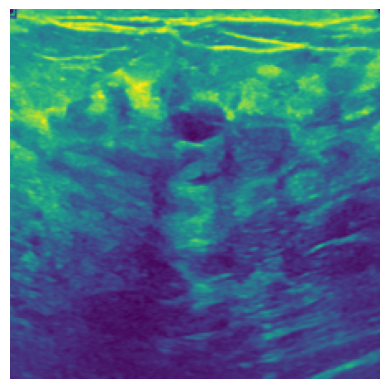

In [116]:

# Convert the tensor to channel-last format
image_np = X_train_dataset[1][0].permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels
plt.show()

In [117]:
# Design the Architecture

class MyModel(nn.Module): 
    def __init__(self,in_channels): 
        super().__init__()
        # Define CNN layers to extract image features 
        self.features_extraction = nn.Sequential(
            # Layer 1: Conv2D layers - 
            nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=3,padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),


            # Layer 2 : Conv2D
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),        
            
            # Layer 3 : Conv2D
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        # Define the classifier 

        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            nn.LazyLinear(128),
            nn.ReLU(),
            #nn.Dropout(p=0.4),

            nn.Linear(128,64),
            nn.ReLU(),
            #nn.Dropout(p=0.4),
            
            nn.Linear(64,3)
        )


    def forward(self,input_features): 
        out = self.features_extraction(input_features)

        out = self.classifier(out)

        return out 
        

In [118]:
class MyModelEnhanced(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 4 (optional but powerful)
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Fix feature size
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [127]:
# Configuration of My model 
learning_rate = 0.02
epochs = 50
loss_function = nn.CrossEntropyLoss()

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [129]:
device

device(type='cuda')

In [130]:
model = MyModelEnhanced(1)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
torch.manual_seed(1123)
# training loop 
for epoch in range(epochs): 
    total_epoch_loss = 0
    for batch_images,batch_labels in X_train_dataloader: 
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # pass forward 
        y_pred = model(batch_images)
        # loss calculate
        loss = loss_function(y_pred,batch_labels)
        
        # Clear the gradient 
        optimizer.zero_grad()
        # Backward propgationabs
        loss.backward()

        # Update weights 
        optimizer.step()
        total_epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} : ",total_epoch_loss/len(X_train_dataloader))
        

Epoch 1 :  0.9990761625139337
Epoch 2 :  0.9345095690928007
Epoch 3 :  0.893482035712192
Epoch 4 :  0.852311720973567
Epoch 5 :  0.7840021629082529
Epoch 6 :  0.7639216529695612
Epoch 7 :  0.7228702761624989
Epoch 8 :  0.683380829660516
Epoch 9 :  0.6062729154762468
Epoch 10 :  0.6040861528170737
Epoch 11 :  0.5879840097929302
Epoch 12 :  0.5393824389106349
Epoch 13 :  0.5066137360899072
Epoch 14 :  0.4687012010499051
Epoch 15 :  0.4416930048089278
Epoch 16 :  0.42768267738191706
Epoch 17 :  0.37885281757304545
Epoch 18 :  0.37814528455859736
Epoch 19 :  0.28975815365189
Epoch 20 :  0.35163727637968567
Epoch 21 :  0.2976445524316085
Epoch 22 :  0.2041568422788068
Epoch 23 :  0.2534242076309104
Epoch 24 :  0.2285624750350651
Epoch 25 :  0.41988634318113327
Epoch 26 :  0.24104771488591245
Epoch 27 :  0.18170033277649628
Epoch 28 :  0.13515330341301465
Epoch 29 :  0.17615206990587085
Epoch 30 :  0.24598094624908348
Epoch 31 :  0.10226110192505937
Epoch 32 :  0.1361096785648873
Epoch 33 : 

In [170]:
# Evaluation of the model : Now the model will stop learning and modification into the exisiting learn parameters
model.eval()

MyModelEnhanced(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [187]:

model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in X_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


In [188]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[69  3  2]
 [ 3 30  0]
 [ 6  2 13]]


In [189]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    target_names=["Benign", "Malignant", "Normal"]  # adjust order
))


              precision    recall  f1-score   support

      Benign       0.88      0.93      0.91        74
   Malignant       0.86      0.91      0.88        33
      Normal       0.87      0.62      0.72        21

    accuracy                           0.88       128
   macro avg       0.87      0.82      0.84       128
weighted avg       0.87      0.88      0.87       128



In [192]:
# torch.save(model.state_dict(), "./models/model_epoch_100.pth")


In [ ]:
#model = MyModel(...)          # recreate architecture
#model.load_state_dict(torch.load("model.pth"))
#model.eval()
